In [2]:
import numpy as np
from BoomboxProcessor import BoomboxProcessor
from train_encoding_model import BoomboxNet
from GenreClassifier import GenreClassifier
import torch.nn as nn
import torch
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from torchmetrics.functional import accuracy as torch_acc
from sklearn.metrics import classification_report
import torch.optim as optim
from torch.utils.data import DataLoader

## Fetch Trajectory Data

In [3]:
data_folder = ["90s_hiphop", "90s_rock", "2010s_pop", "classical", "country"]

boombox = BoomboxProcessor(verbose=True)
boombox.load_trajectories(data_folder) # load trajectories
boombox.load_encoding_model('models/model_50000.pt', BoomboxNet)
boombox.encode_trajectories() # encode trajectories
boombox.split_encoded_trajectories(10)
trajectories, labels = boombox.get_all_songlet_trajectories() # get all songlet trajectories

Loaded 93 trajectories from 90s_hiphop
Loaded 70 trajectories from 90s_rock
Loaded 67 trajectories from 2010s_pop
Loaded 60 trajectories from classical
Loaded 75 trajectories from country


100%|██████████| 75/75 [00:00<00:00, 162.73it/s]


## Encode Trajectory Data for Classification

In [4]:
one_hot_encoder = OneHotEncoder()
labels = one_hot_encoder.fit_transform(labels.reshape(-1, 1)).toarray()

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(trajectories, labels, test_size=0.15, random_state=42)
# convert to torch tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

In [7]:
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])

In [8]:
# does y_test contain all the genres?
print(y_test.sum(axis=0))

tensor([18.,  8.,  7.,  8., 14.])


In [9]:
trainDataLoader = DataLoader(list(zip(x_train, y_train)), batch_size=8, shuffle=True)
testDataLoader = DataLoader(list(zip(x_test, y_test)), batch_size=8, shuffle=True)

## Model

In [10]:
class GenreCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(GenreCNN, self).__init__()
        self.conv_group = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(in_features=128*1*48, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_group(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

## Train and Evaluate Model

In [61]:
# Initialize model
model = GenreCNN().to('cuda')

In [62]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [63]:
# Define the number of epochs
num_epochs = 50

# Initialize empty lists to store the training and test accuracy, and loss at each epoch
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

In [64]:
# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Initialize training loss and accuracy
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Iterate over the training data
    for inputs, labels in trainDataLoader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.argmax(dim=1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        train_correct += (outputs.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
        train_total += labels.size(0)

    # Calculate average training loss and accuracy
    train_loss /= len(trainDataLoader.dataset)
    train_acc = train_correct / train_total

    # Set the model to evaluation mode
    model.eval()

    # Initialize test accuracy
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    # Iterate over the test data
    with torch.no_grad():
        for inputs, labels in testDataLoader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            
            # Forward pass
            outputs = model(inputs)

            # Update test accuracy
            test_correct += (outputs.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
            test_total += labels.size(0)
            test_loss = criterion(outputs, labels.argmax(dim=1)).item()

    # Calculate test accuracy
    test_acc = test_correct / test_total

    # Print the training and test accuracy and loss at each epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Test Acc: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, train_acc, test_acc))

    # Append the training and test accuracy and loss to the corresponding lists
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

# Save the trained model
torch.save(model.state_dict(), 'genre-classification-{}.pt'.format(num_epochs))


Epoch [1/50], Train Loss: 1.2683, Train Acc: 0.6452, Test Acc: 0.4909
Epoch [2/50], Train Loss: 1.1381, Train Acc: 0.7645, Test Acc: 0.8545
Epoch [3/50], Train Loss: 0.9249, Train Acc: 0.9871, Test Acc: 0.9818
Epoch [4/50], Train Loss: 0.9118, Train Acc: 0.9968, Test Acc: 1.0000
Epoch [5/50], Train Loss: 0.9094, Train Acc: 0.9968, Test Acc: 1.0000
Epoch [6/50], Train Loss: 0.9090, Train Acc: 0.9968, Test Acc: 1.0000
Epoch [7/50], Train Loss: 0.9087, Train Acc: 0.9968, Test Acc: 1.0000
Epoch [8/50], Train Loss: 0.9093, Train Acc: 0.9968, Test Acc: 1.0000
Epoch [9/50], Train Loss: 0.9118, Train Acc: 0.9968, Test Acc: 1.0000
Epoch [10/50], Train Loss: 0.9180, Train Acc: 0.9871, Test Acc: 0.9818
Epoch [11/50], Train Loss: 0.9140, Train Acc: 0.9935, Test Acc: 1.0000
Epoch [12/50], Train Loss: 0.9092, Train Acc: 0.9968, Test Acc: 1.0000
Epoch [13/50], Train Loss: 0.9117, Train Acc: 0.9935, Test Acc: 1.0000
Epoch [14/50], Train Loss: 0.9089, Train Acc: 0.9968, Test Acc: 1.0000
Epoch [15/50], 

## Testing Code

In [65]:
import torch
import torch.nn as nn


# Load the saved model
model = GenreCNN(num_classes=5).to('cuda')
model.load_state_dict(torch.load('genre-classification-50.pt'))
model.eval()

# Pass the test data through the model
with torch.no_grad():
    for inputs, labels in testDataLoader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        # Print the output predictions
        print(outputs.argmax(dim=1), labels.argmax(dim=1))


tensor([1, 4, 0, 1, 2, 0, 0, 3], device='cuda:0') tensor([1, 4, 0, 1, 2, 0, 0, 3], device='cuda:0')
tensor([0, 0, 0, 0, 4, 4, 4, 4], device='cuda:0') tensor([0, 0, 0, 0, 4, 4, 4, 4], device='cuda:0')
tensor([1, 4, 0, 1, 3, 2, 0, 1], device='cuda:0') tensor([1, 4, 0, 1, 3, 2, 0, 1], device='cuda:0')
tensor([1, 0, 4, 1, 2, 4, 4, 4], device='cuda:0') tensor([1, 0, 4, 1, 2, 4, 4, 4], device='cuda:0')
tensor([4, 3, 3, 4, 3, 1, 4, 0], device='cuda:0') tensor([4, 3, 3, 4, 3, 1, 4, 0], device='cuda:0')
tensor([0, 3, 2, 2, 0, 3, 4, 0], device='cuda:0') tensor([0, 3, 2, 2, 0, 3, 4, 0], device='cuda:0')
tensor([0, 2, 0, 2, 0, 3, 0], device='cuda:0') tensor([0, 2, 0, 2, 0, 3, 0], device='cuda:0')


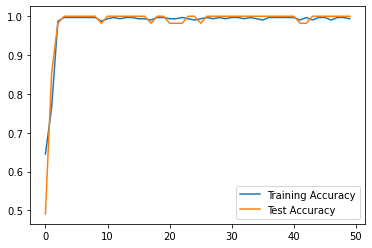

In [66]:
import matplotlib.pyplot as plt

plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.legend()

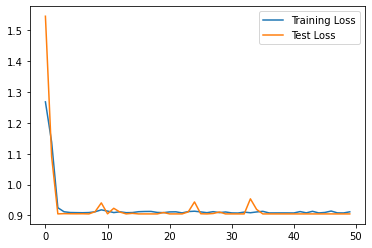

In [67]:
plt.plot(train_loss_list, label='Training Loss')
plt.legend()